# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [23]:
# Load pickled data
import pickle
import numpy as np
import csv
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
from sklearn import preprocessing
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

training_file   = "../train.p"
validation_file = "../valid.p"
testing_file    = "../test.p" 
labels_file     = "signnames.csv"

colorspace = "BW"  # ["RGB", "YUV", "LAB", "BW"]
show_signs = False

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test,  y_test  = test['features'],  test['labels']

# check if we have equal amount of samples in the feature and label spaces
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# Read in label descriptions
labels = []
with open(labels_file, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    for row in spamreader:
        if row[0].isdecimal():
            labels.append(row[1])

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [24]:
n_train       = X_train.shape[0]
n_validation  = X_valid.shape[0]
n_test        = X_test.shape[0]
image_shape   = X_train.shape[1:]
n_classes     = np.unique(y_train).size

n_total = n_train + n_validation + n_test
print("Training dataset size:    %d (%.2f%%) samples" % (n_train, 100*n_train/n_total))
print("Validation dataset size:  %d (%.2f%%) samples" % (n_validation, 100*n_validation/n_total))
print("Test dataset size:        %d (%.2f%%) samples" % (n_test, 100*n_test/n_total))
print("Image data shape:        ", image_shape)
print("Number of classes:       ", n_classes)

Training dataset size:    34799 (67.13%) samples
Validation dataset size:  4410 (8.51%) samples
Test dataset size:        12630 (24.36%) samples
Image data shape:         (32, 32, 3)
Number of classes:        43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [25]:
# Check how many traffic sign example we have in each class within the training dataset
class_indexes_train = []
class_indexes_valid = []
class_indexes_test  = []
for i in range(n_classes):
    class_indexes_train.append(np.where(y_train==i))
    class_indexes_valid.append(np.where(y_valid==i))
    class_indexes_test.append(np.where(y_test==i))

df = pd.DataFrame({
    'Traffic sign description': labels,
    'Training'   : [len(class_indexes_train[i][0]) for i in range(n_classes)],
    'Validation' : [len(class_indexes_valid[i][0]) for i in range(n_classes)],
    'Test'       : [len(class_indexes_test[i][0])  for i in range(n_classes)]
})

pd.options.display.width = 100
pd.options.display.max_colwidth = 90
df.reindex(columns=['Traffic sign description', 'Training', 'Validation', 'Test'])

,Traffic sign description,Training,Validation,Test
0,Speed limit (20km/h),180,30,60
1,Speed limit (30km/h),1980,240,720
2,Speed limit (50km/h),2010,240,750
3,Speed limit (60km/h),1260,150,450
4,Speed limit (70km/h),1770,210,660
5,Speed limit (80km/h),1650,210,630
6,End of speed limit (80km/h),360,60,150
7,Speed limit (100km/h),1290,150,450
8,Speed limit (120km/h),1260,150,450
9,No passing,1320,150,480


In [26]:
def normalize_for_imshow(image):
    # uint8: leave in range [0-255]
    if image.dtype == np.dtype('uint8'):
        return image
    else: # float32: scale value to range [0, 1]
        if np.min(image) < 0:
            return (image + 1.0) / 2.0
        else:
            return (image - image.mean()) / image.std() 
        

def visualize_dataset(data, indexes, imgs_per_class=10):
    #norm = colors.LogNorm(X_mean + 0.5 * X_std, 1.0, clip='True')
    #norm = colors.LogNorm(vmin=-1.0, vmax=1.0)
    #norm = colors.LogNorm(image.mean() + 0.5 * image.std(), image.max(), clip='True')
    print("min val: %f, max val: %f" % (np.min(data), np.max(data)))
    print("mean: %f, std: %f" %(data.mean(), data.std()))
    data_conv = np.copy(data)

    imshow_cmap = None
    if data.shape[-1] == 1:  # or colorspace == "BW"
        imshow_cmap = "gray"

    if colorspace == "YUV":
        for i, img in enumerate(data):
            data_conv[i] = np.reshape(cv2.cvtColor(img, cv2.COLOR_YUV2RGB), data.shape[1:])
    elif colorspace == "LAB":
        for i, img in enumerate(data):
            data_conv[i] = np.reshape(cv2.cvtColor(img, cv2.COLOR_Lab2RGB), data.shape[1:])
   
    for sign_class in range(n_classes):
        print("Showing example images from class %d: %s" % (sign_class, labels[sign_class]))
        plt.figure(figsize=(10,3))
        rand_items = random.sample(list(indexes[sign_class][0]), imgs_per_class)
        for count, i in zip(range(imgs_per_class), rand_items):
            image = data_conv[i].squeeze()
            ax = plt.subplot(1, imgs_per_class, count+1)
            ax.set_title(i, fontdict={'fontsize': 8})
            ax.set_axis_off()
            ax.imshow(normalize_for_imshow(image), cmap=imshow_cmap) #, vmin=-1.0, vmax=1.0, cmap="gray", interpolation="lanczos")

        plt.show(True)

if show_signs == True:
    # visualize original dataset
    visualize_dataset(X_train, class_indexes_train, imgs_per_class=10)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [27]:
X = np.concatenate((X_train, X_valid, X_test))
X_mean = X.flatten().mean()
X_std  = X.flatten().std()
print("total mean: %d" % X_mean)
print("total std:  %d" % X_std)

total mean: 82
total std:  68


In [117]:
def equalize_dataset(data, colorspace_conversion=None):
    clipLimit = 1.0
    grid_size = (2,2)
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=grid_size)

    if colorspace == "BW":
        data_norm = np.zeros((data.shape[0], data.shape[1], data.shape[2], 1), dtype=np.uint8)
    else:
        data_norm = np.copy(data)

    if colorspace_conversion == "RGB":
        print("no equalization for RGB images!")
        # no equalization for RGB images, it only makes sense for brightness or luminosity channels!

    elif colorspace_conversion == "YUV":
        for i, img in enumerate(data):
            data_norm[i] = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
            y, u, v = cv2.split(data_norm[i])
            y = clahe.apply(y)
            data_norm[i] = np.reshape(cv2.merge((y,u,v)), data_norm.shape[1:])

    elif colorspace_conversion == "LAB":
        for i, img in enumerate(data):
            data_norm[i] = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
            l, a, b = cv2.split(data_norm[i])
            l = clahe.apply(l)
            data_norm[i] = np.reshape(cv2.merge((l,a,b)), data_norm.shape[1:])

    elif colorspace_conversion=="BW":
        for i, img in enumerate(data):
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            data_norm[i] = np.reshape(clahe.apply(img),  data_norm.shape[1:])

        # update image_shape for one layer b/w image
        image_shape = data_norm.shape[1:]

    else:
        print("No colorspace conversion set!")
        data_norm[i] = clahe.apply(data[i])

    return data_norm


def center_normaize(data, mean, std):
    data = data.astype('float32')
    return (data - mean) / std


X_train_norm = equalize_dataset(X_train, colorspace)
X_valid_norm = equalize_dataset(X_valid, colorspace)
X_test_norm  = equalize_dataset(X_test, colorspace)
print("before normalization: min val: %f, max val: %f" % (np.min(X_train_norm), np.max(X_train_norm)))

white_pixels_cnt = len(np.where(X_train == 255)[0])
black_pixels_cnt = len(np.where(X_train == 0)[0])
print("White & black pixels before equalization: %d, %d" % (white_pixels_cnt, black_pixels_cnt))
white_pixels_cnt = len(np.where(X_train_norm == 255)[0])
black_pixels_cnt = len(np.where(X_train_norm == 0)[0])
print("White & black pixels after equalization: %d, %d" % (white_pixels_cnt, black_pixels_cnt))

# Value normalization into -1 to +1 range
X_mean = 128
X_std = 128
X_train_norm = center_normaize(X_train_norm, X_mean, X_std)
X_valid_norm = center_normaize(X_valid_norm, X_mean, X_std)
X_test_norm  = center_normaize(X_test_norm,  X_mean, X_std)
print("normalized data with mean=%.3f and scale=%.3f" % (X_mean, X_std))
print("after normalization min val: %f, max val: %f" % (np.min(X_train_norm), np.max(X_train_norm)))

datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False,
    zca_whitening=False,
    zca_epsilon=1e-7,
    shear_range=0,
    zoom_range=0.1,
    rescale=None
)

datagen.fit(X_train_norm, augment=True)

before normalization: min val: 5.000000, max val: 255.000000
White & black pixels before equalization: 3678057, 206
White & black pixels after equalization: 1024219, 0
normalized data with mean=128.000 and scale=128.000
after normalization min val: -0.960938, max val: 0.992188


### Balance dataset (equal amount of training samples for each class)

In [8]:
# find class with least exmpales
samples = []
for class_nr in range(n_classes):
    samples.append(sum(class_indexes_train[class_nr][0]))

min_size = np.argmin(np.array(samples))

X_train_norm_balanced = np.zeros((min_size, X_train_norm.shape[1], X_train_norm.shape[2], X_train_norm.shape[3]), dtype=np.float32)
y_train_balanced = np.zeros((X_train_norm.shape), dtype=np.int32)

print("class with least examples in training dataset: %d" % min_size)
for class_nr in range(n_classes):
    rand_items = random.sample(list(indexes[sign_class][0]), imgs_per_class)
    #X_train_norm_balanced.conca 


class with least examples in training dataset: 41


NameError: name 'indexes' is not defined

X_train_batch.shape:  (5000, 32, 32, 1)
min val: -0.953125, max val: 0.992188
mean: -0.167576, std: 0.583831
Showing example images from class 0: Speed limit (20km/h)


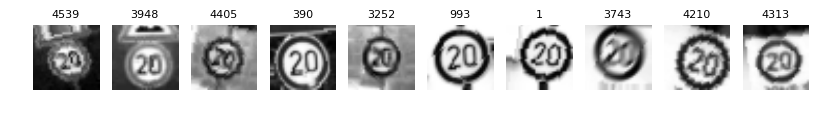

Showing example images from class 1: Speed limit (30km/h)


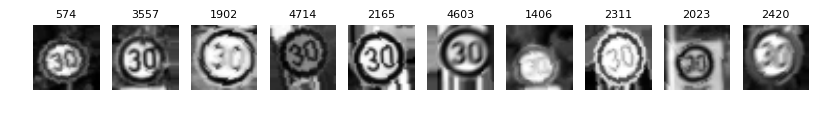

Showing example images from class 2: Speed limit (50km/h)


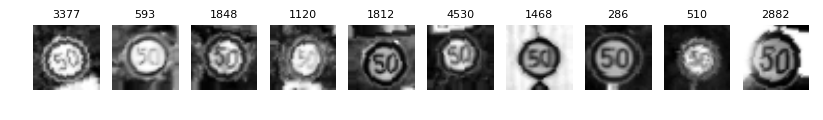

Showing example images from class 3: Speed limit (60km/h)


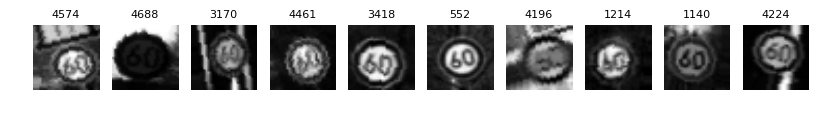

Showing example images from class 4: Speed limit (70km/h)


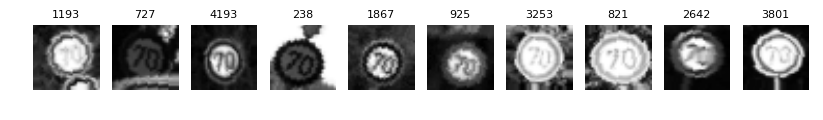

Showing example images from class 5: Speed limit (80km/h)


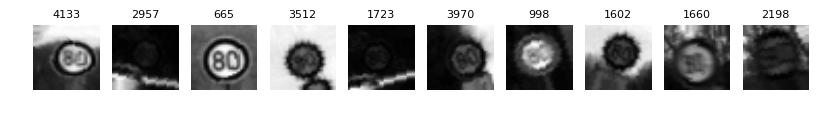

Showing example images from class 6: End of speed limit (80km/h)


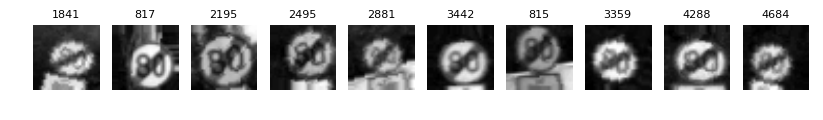

Showing example images from class 7: Speed limit (100km/h)


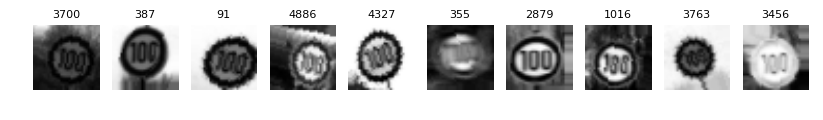

Showing example images from class 8: Speed limit (120km/h)


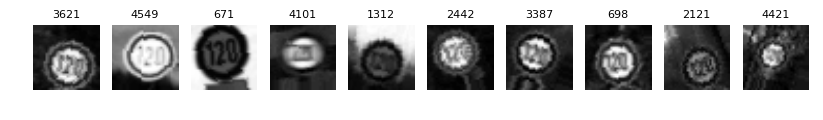

Showing example images from class 9: No passing


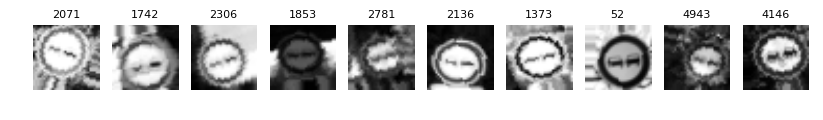

Showing example images from class 10: No passing for vehicles over 3.5 metric tons


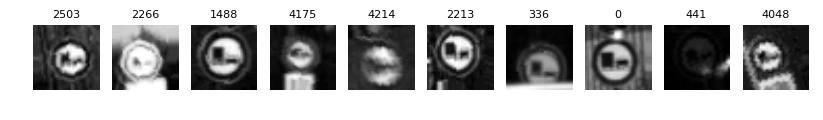

Showing example images from class 11: Right-of-way at the next intersection


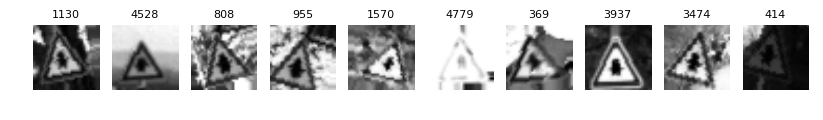

Showing example images from class 12: Priority road


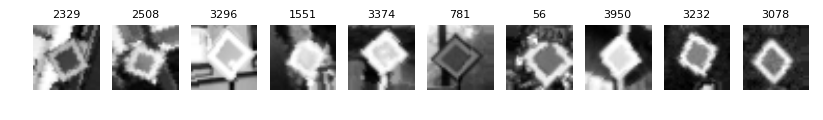

Showing example images from class 13: Yield


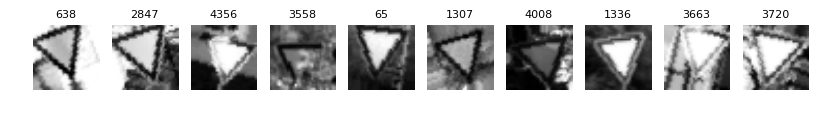

Showing example images from class 14: Stop


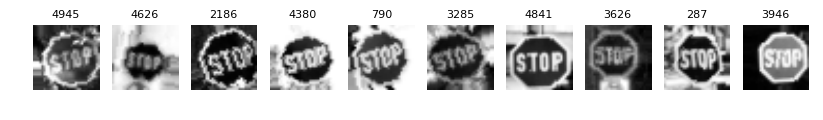

Showing example images from class 15: No vehicles


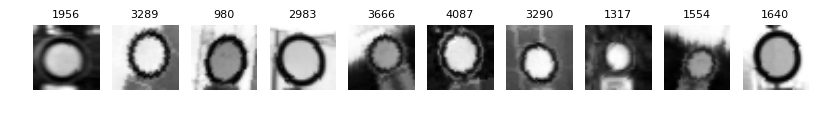

Showing example images from class 16: Vehicles over 3.5 metric tons prohibited


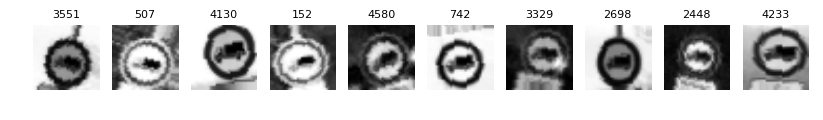

Showing example images from class 17: No entry


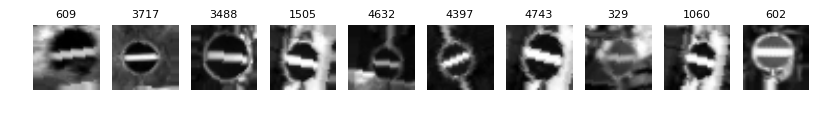

Showing example images from class 18: General caution


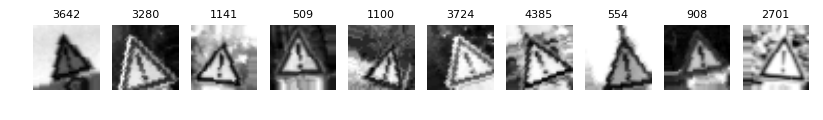

Showing example images from class 19: Dangerous curve to the left


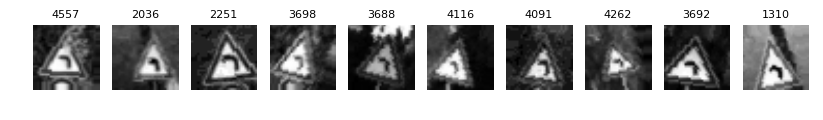

Showing example images from class 20: Dangerous curve to the right


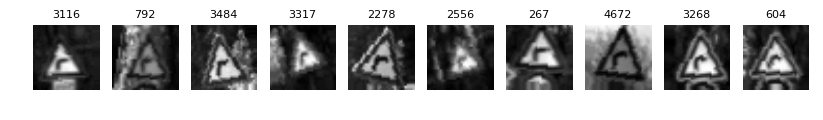

Showing example images from class 21: Double curve


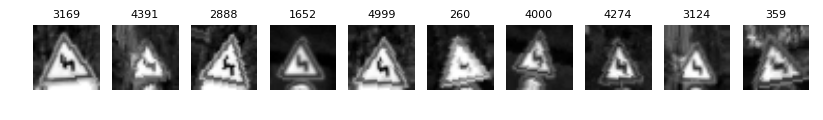

Showing example images from class 22: Bumpy road


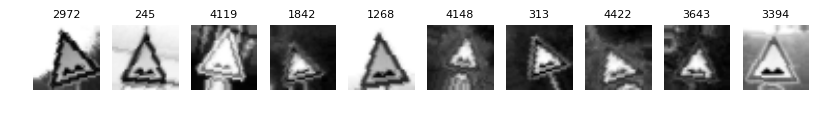

Showing example images from class 23: Slippery road


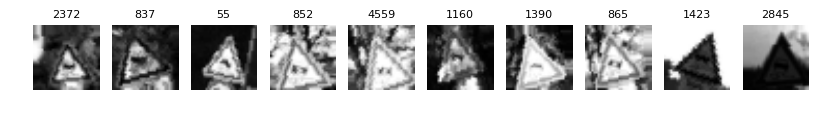

Showing example images from class 24: Road narrows on the right


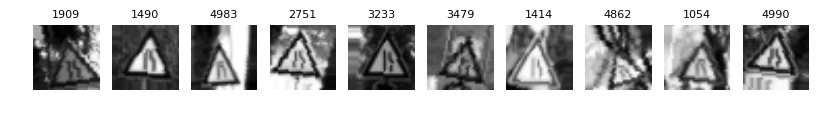

Showing example images from class 25: Road work


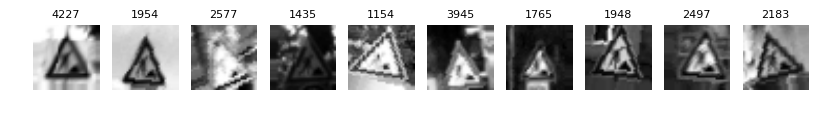

Showing example images from class 26: Traffic signals


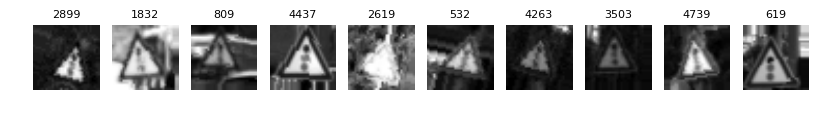

Showing example images from class 27: Pedestrians


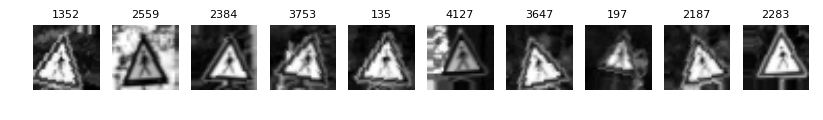

Showing example images from class 28: Children crossing


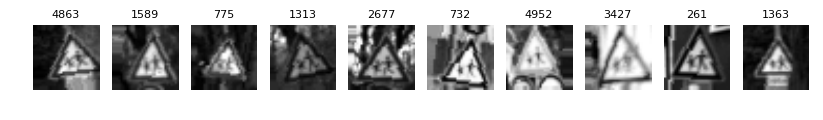

Showing example images from class 29: Bicycles crossing


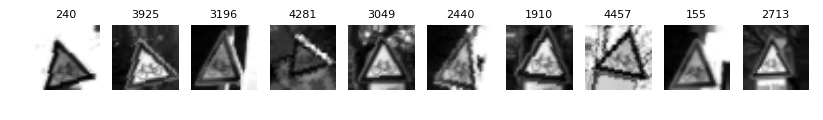

Showing example images from class 30: Beware of ice/snow


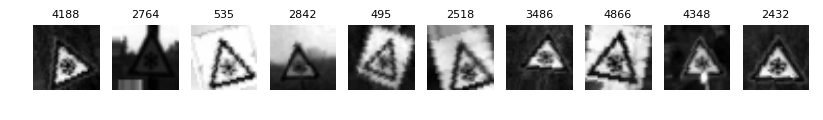

Showing example images from class 31: Wild animals crossing


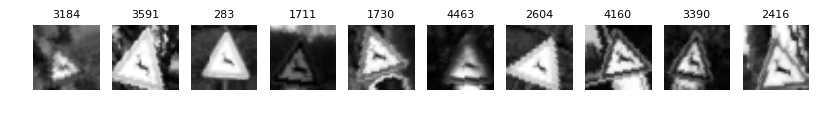

Showing example images from class 32: End of all speed and passing limits


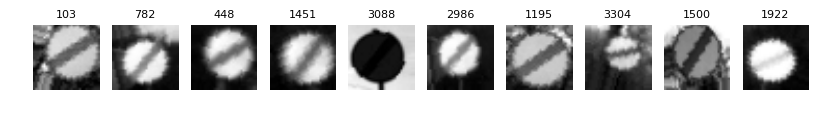

Showing example images from class 33: Turn right ahead


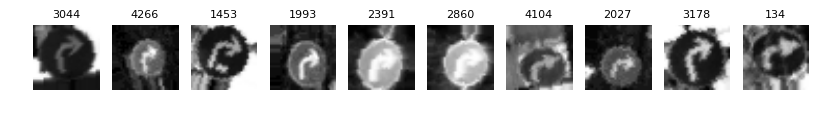

Showing example images from class 34: Turn left ahead


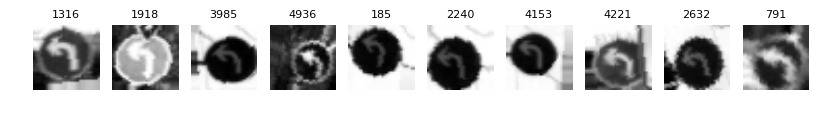

Showing example images from class 35: Ahead only


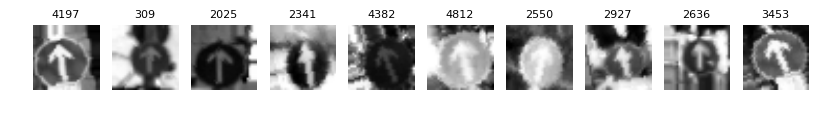

Showing example images from class 36: Go straight or right


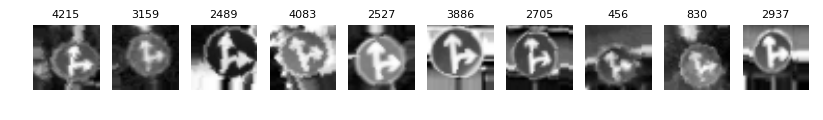

Showing example images from class 37: Go straight or left


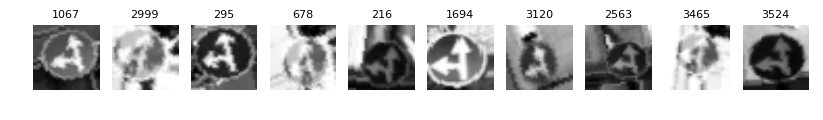

Showing example images from class 38: Keep right


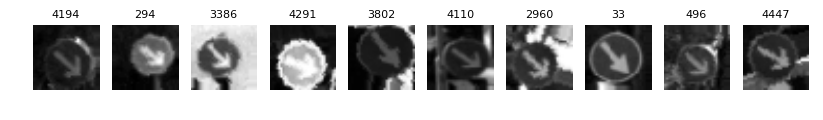

Showing example images from class 39: Keep left


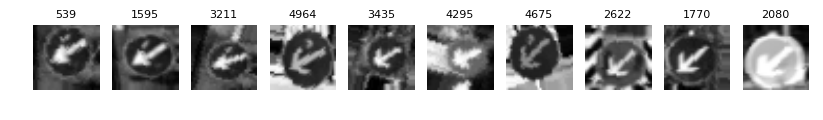

Showing example images from class 40: Roundabout mandatory


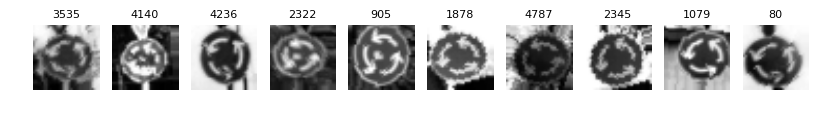

Showing example images from class 41: End of no passing


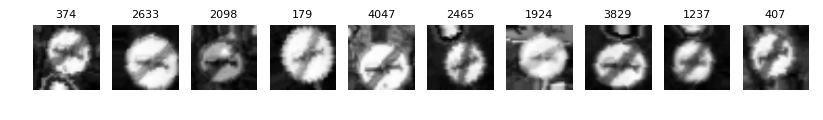

Showing example images from class 42: End of no passing by vehicles over 3.5 metric tons


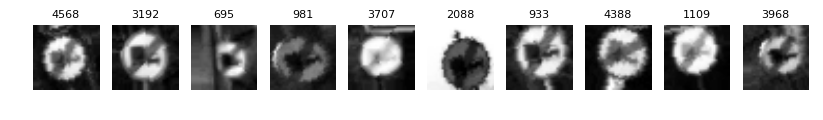

In [118]:
# show preprocessed images
if True: #show_signs == True:
    X_train_batch, y_train_batch = datagen.flow(X_train_norm, y_train, batch_size=5000, shuffle=True).next()
    indexes  = []
    for i in range(n_classes):
        indexes.append(np.where(y_train_batch==i))

    print("X_train_batch.shape: ", X_train_batch.shape)
    visualize_dataset(X_train_batch, indexes, 10)

### Model Architecture

In [134]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

# really make sure it gets the dimensions right!
if colorspace == "BW":
    image_shape = (image_shape[0], image_shape[1], 1)

def maxpool2d(x, k=2, s=2, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding=padding)

def conv2d(x, W, b, strides=1, padding='VALID'):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

#new_height = (input_height - filter_height + 2 * P)/S + 1

# Store layers weight & bias
weights1 = {
    'wc1':     tf.Variable(tf.random_normal([5, 5, image_shape[2],  6], mean=mu, stddev=sigma)),
    'wc2':     tf.Variable(tf.random_normal([5, 5,  6, 16], mean=mu, stddev=sigma)),
    'wfull1':  tf.Variable(tf.random_normal([400, 120], mean=mu, stddev=sigma)),
    'wfull2':  tf.Variable(tf.random_normal([120,  84], mean=mu, stddev=sigma)),
    'out':     tf.Variable(tf.random_normal([84,  n_classes], mean=mu, stddev=sigma))
}

biases1 = {
    'bc1':     tf.Variable(tf.random_normal([6], mean=mu, stddev=sigma)),
    'bc2':     tf.Variable(tf.random_normal([16], mean=mu, stddev=sigma)),
    'bfull1':  tf.Variable(tf.random_normal([120], mean=mu, stddev=sigma)),
    'bfull2':  tf.Variable(tf.random_normal([84], mean=mu, stddev=sigma)),
    'out':     tf.Variable(tf.random_normal([n_classes], mean=mu, stddev=sigma))
}

def LeNet1(x, keep_prob):    
    # Layer 1: Convolutional. Input = 32x32ximage_shape[2]. Output = 28x28x6.
    conv1 = conv2d(x, weights1['wc1'], biases1['bc1'], strides=1, padding='VALID')
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2, s=2)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2 = conv2d(conv1, weights1['wc2'], biases1['bc2'], padding='VALID')
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2, s=2)
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(conv2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    layer3 = tf.add(tf.matmul(flat, weights1['wfull1']), biases1['bfull1'])
    # Activation.
    layer3 = tf.nn.elu(layer3)
    # Dropout
    layer3 = tf.nn.dropout(layer3, keep_prob)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    layer4 = tf.add(tf.matmul(layer3, weights1['wfull2']), biases1['bfull2'])
    # Activation.
    layer4 = tf.nn.elu(layer4)
    # Dropout
    layer4 = tf.nn.dropout(layer4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    logits = tf.add(tf.matmul(layer4, weights1['out']), biases1['out'])

    return logits


# Store layers weight & bias
weights2 = {
    'wc1':     tf.Variable(tf.random_normal([5, 5, image_shape[2],  32], mean=mu, stddev=sigma)),
    'wc2':     tf.Variable(tf.random_normal([5, 5, 32, 64], mean=mu, stddev=sigma)),
    'wc3':     tf.Variable(tf.random_normal([5, 5, 64, 128], mean=mu, stddev=sigma)),
    'wfull1':  tf.Variable(tf.random_normal([2048, 400], mean=mu, stddev=sigma)),
    'wfull2':  tf.Variable(tf.random_normal([400,  200], mean=mu, stddev=sigma)),
    'out':     tf.Variable(tf.random_normal([200,  n_classes], mean=mu, stddev=sigma))
}

biases2 = {
    'bc1':     tf.Variable(tf.random_normal([32], mean=mu, stddev=sigma)),
    'bc2':     tf.Variable(tf.random_normal([64], mean=mu, stddev=sigma)),
    'bc3':     tf.Variable(tf.random_normal([128], mean=mu, stddev=sigma)),
    'bfull1':  tf.Variable(tf.random_normal([400], mean=mu, stddev=sigma)),
    'bfull2':  tf.Variable(tf.random_normal([200], mean=mu, stddev=sigma)),
    'out':     tf.Variable(tf.random_normal([n_classes], mean=mu, stddev=sigma))
}

def LeNet2(x, keep_prob):
    # Layer 1: Convolutional. Input = 32x32ximage_shape[2]. Output = 32x32x64.
    conv1 = conv2d(x, weights2['wc1'], biases2['bc1'], strides=1, padding='SAME')
    # Pooling. Input = 32x32x64. Output = 16x16x64.
    conv1 = maxpool2d(conv1, k=2, s=2, padding='SAME')
    
    # Layer 2: Convolutional. Output = 16x16x128.
    conv2 = conv2d(conv1, weights2['wc2'], biases2['bc2'], padding='SAME')
    # Pooling. Input = 16x16x64. Output = 8x8x128.
    conv2 = maxpool2d(conv2, k=2, s=2, padding='SAME')
    
    # Layer 3: Convolutional. Output = 8x8x256.
    conv3 = conv2d(conv2, weights2['wc3'], biases2['bc3'], padding='SAME')
    # Pooling. Input = 8x8x256. Output = 4x4x256.
    conv3 = maxpool2d(conv3, k=2, s=2, padding='SAME')
    # Flatten. Input = 4x4x256. Output = 2048.
    flat = flatten(conv3)

    # Layer 4: Fully Connected. Input = 4096. Output = 400.
    layer4 = tf.add(tf.matmul(flat, weights2['wfull1']), biases2['bfull1'])
    # Activation.
    layer4 = tf.nn.elu(layer4) 
    # Dropout
    layer4 = tf.nn.dropout(layer4, keep_prob)
    
    # Layer 5: Fully Connected. Input = 400. Output = 200.
    layer5 = tf.add(tf.matmul(layer4, weights2['wfull2']), biases2['bfull2'])
    # Activation.
    layer5 = tf.nn.elu(layer5)
    # Dropout
    layer5 = tf.nn.dropout(layer5, keep_prob)
    
    # Layer 6: Fully Connected. Input = 200. Output = n_classes.
    logits = tf.add(tf.matmul(layer5, weights2['out']), biases2['out'])

    net = {"conv1": conv1, "conv2": conv2, "conv3": conv3, "layer4": layer4, "layer5": layer5, "logits": logits}
    #net = [conv1, conv2, conv3, layer4, layer5, logits]
    return net

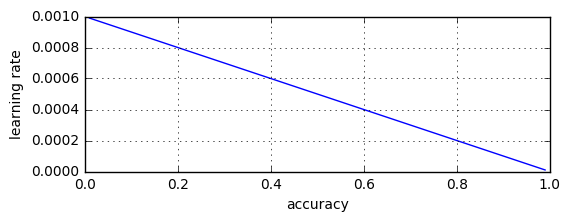

(None, None)

In [143]:
def rate_calc(accuracy, rate_start):
    return rate_start - accuracy*rate_start
accuracy = np.arange(0.01, 1.0, 0.01)
fig = plt.figure(figsize=(6,2))
plt.plot(accuracy, rate_calc(accuracy, 0.001))
plt.xlabel("accuracy"), plt.ylabel("learning rate")
plt.grid(), plt.show()

In [124]:
# clean-up tensorflow, in case a model should be restored
tf.reset_default_graph()
sess.close()

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [137]:
x = tf.placeholder(tf.float32, (None, 32, 32, image_shape[2]))
y = tf.placeholder(tf.int32, (None))
learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

# training the model
rate = 0.005
rate_start = 0.001

dropout = 0.7  # Dropout, probability to keep units
EPOCHS = 60

model = "LeNet2"

if model == "LeNet1":
    net = LeNet1(x, keep_prob)
    logits = net["logits"]
    BATCH_SIZE = 8192
    save_filename = "./lenet1"
else:
    net = LeNet2(x, keep_prob)
    logits = net["logits"]
    BATCH_SIZE = 2048
    save_filename = "./lenet2"

save_filename += "-" + colorspace

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.9, beta2=0.999)
training_operation = optimizer.minimize(loss_operation)

### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver(filename=save_filename)


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))

    return total_accuracy / num_examples


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Trying to load model and variables from '%s'" % save_filename)
    print("Last checkpoint: ", tf.train.latest_checkpoint('.'))
    #saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, save_filename)
    
    num_examples = X_train_norm.shape[0]
    validation_accuracy = 0.01
    print("Training...")
    for step in range(EPOCHS):
        batch_cnt = num_examples//BATCH_SIZE

        #X_train_norm, y_train = shuffle(X_train_norm, y_train)
        #for batch, offset in zip(range(batch_cnt), range(0, num_examples, BATCH_SIZE)):
        #    end = offset + BATCH_SIZE
        #    batch_x, batch_y = X_train_norm[offset:end], y_train[offset:end]
        batches = 0
        rate = rate_calc(validation_accuracy, rate_start)
        for X_train_batch, y_train_batch in datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE, shuffle=True):
            #X_train_batch, y_train_batch = datagen.flow(X_train_norm, y_train, batch_size=BATCH_SIZE, shuffle=True).next()
            sess.run(training_operation, feed_dict={learning_rate: rate, x: X_train_batch, y: y_train_batch, keep_prob: dropout})
            batches += 1
            if batches > batch_cnt:
                break
        loss = sess.run(loss_operation, feed_dict={x: X_train_batch, y: y_train_batch, keep_prob: 1.0})
        validation_accuracy = evaluate(X_valid_norm, y_valid)
        print("Epoch %d (learning rate: %.5f) - Loss: %.5f, Validation Accuracy: %.5f" %
                (step + 1, rate, loss, validation_accuracy))
        saver.save(sess, save_filename, global_step=step)

    saver.save(sess, save_filename)
    print("Model saved")

Trying to load model and variables from './lenet2-BW'
./lenet2-BW-46
Training...
Epoch 1 (learning rate: 0.00099) - Loss: 3.45219, Validation Accuracy: 0.12766
Epoch 2 (learning rate: 0.00087) - Loss: 3.16722, Validation Accuracy: 0.17823
Epoch 3 (learning rate: 0.00082) - Loss: 2.87534, Validation Accuracy: 0.25533
Epoch 4 (learning rate: 0.00074) - Loss: 2.55050, Validation Accuracy: 0.30816
Epoch 5 (learning rate: 0.00069) - Loss: 2.25111, Validation Accuracy: 0.37302
Epoch 6 (learning rate: 0.00063) - Loss: 1.97109, Validation Accuracy: 0.43175
Epoch 7 (learning rate: 0.00057) - Loss: 1.68963, Validation Accuracy: 0.48163
Epoch 8 (learning rate: 0.00052) - Loss: 1.58941, Validation Accuracy: 0.49478
Epoch 9 (learning rate: 0.00051) - Loss: 1.45256, Validation Accuracy: 0.53651
Epoch 10 (learning rate: 0.00046) - Loss: 1.36382, Validation Accuracy: 0.57415
Epoch 11 (learning rate: 0.00043) - Loss: 1.28435, Validation Accuracy: 0.59161
Epoch 12 (learning rate: 0.00041) - Loss: 1.2354

KeyboardInterrupt: 

In [138]:
# Test on whole test dataset
model = "LeNet2"
if model == "LeNet1":
    net = LeNet1(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet1"
else:
    net = LeNet2(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet2"

load_filename += "-" + colorspace

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, load_filename)
    test_accuracy = evaluate(X_test_norm, y_test)
    print("Test Accuracy = %.3f" % test_accuracy)

INFO:tensorflow:Restoring parameters from ./lenet2-BW-12
Test Accuracy = 0.648


In [88]:
# Test on test dataset, for each class
model = "LeNet2"
if model == "LeNet1":
    net = LeNet1(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet1"
else:
    net = LeNet2(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet2"

load_filename += "-" + colorspace

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, load_filename)
    for i, sign in enumerate(class_indexes_test):
        test_accuracy = evaluate(X_test_norm[sign[0]], y_test[sign[0]])
        print("Test Accuracy (class %d)= %.3f" %  (i, test_accuracy))


INFO:tensorflow:Restoring parameters from ./lenet2-BW-59
Test Accuracy (class 0)= 0.217
Test Accuracy (class 1)= 0.842
Test Accuracy (class 2)= 0.707
Test Accuracy (class 3)= 0.818
Test Accuracy (class 4)= 0.895
Test Accuracy (class 5)= 0.570
Test Accuracy (class 6)= 0.833
Test Accuracy (class 7)= 0.727
Test Accuracy (class 8)= 0.796
Test Accuracy (class 9)= 0.902
Test Accuracy (class 10)= 0.962
Test Accuracy (class 11)= 0.860
Test Accuracy (class 12)= 0.971
Test Accuracy (class 13)= 0.994
Test Accuracy (class 14)= 0.985
Test Accuracy (class 15)= 0.986
Test Accuracy (class 16)= 1.000
Test Accuracy (class 17)= 0.878
Test Accuracy (class 18)= 0.713
Test Accuracy (class 19)= 0.517
Test Accuracy (class 20)= 0.822
Test Accuracy (class 21)= 0.189
Test Accuracy (class 22)= 0.775
Test Accuracy (class 23)= 0.627
Test Accuracy (class 24)= 0.567
Test Accuracy (class 25)= 0.856
Test Accuracy (class 26)= 0.806
Test Accuracy (class 27)= 0.200
Test Accuracy (class 28)= 0.720
Test Accuracy (class 29)=

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

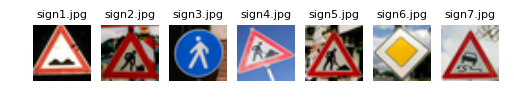

In [132]:
import os
import matplotlib.image as mpimg
import scipy

test_images = []
test_labels = [22, 25, 27, 25, 25, 12, 23]
img_src_folder = "extra-examples/"
imagefile_list = sorted(os.listdir(img_src_folder))
for count, imagefile in enumerate(imagefile_list):
    image = mpimg.imread(img_src_folder + imagefile)
    img = scipy.misc.imresize(image, (32, 32), interp="lanczos")
    ax = plt.subplot(1, len(imagefile_list), count+1)
    ax.set_title(imagefile, fontdict={'fontsize': 8})
    ax.set_axis_off()
    ax.imshow(img) #, cmap=imshow_cmap)
    test_images.append(img)

plt.show(True)

# equalize and normalize data
test_images_norm = equalize_dataset(np.array(test_images), colorspace)
test_images_norm = center_normaize(test_images_norm, X_mean, X_std)

### Predict the Sign Type and show top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet2-BW-12


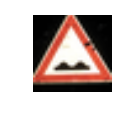

Wrong sign detection!
Sign detection result probabilites in percent:
Class 11 -              Right-of-way at the next intersection: 31.97%
Class 21 -                                       Double curve: 20.45%
Class 30 -                                 Beware of ice/snow: 18.19%
Class 23 -                                      Slippery road: 16.50%
Class 31 -                              Wild animals crossing: 4.27%


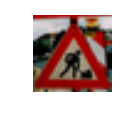

Wrong sign detection!
Sign detection result probabilites in percent:
Class 11 -              Right-of-way at the next intersection: 46.73%
Class 25 -                                          Road work: 27.80%
Class 28 -                                  Children crossing: 11.74%
Class 26 -                                    Traffic signals: 8.61%
Class 23 -                                      Slippery road: 1.60%


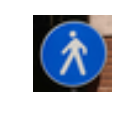

Wrong sign detection!
Sign detection result probabilites in percent:
Class 35 -                                         Ahead only: 76.15%
Class 34 -                                    Turn left ahead: 6.24%
Class 36 -                               Go straight or right: 2.98%
Class 33 -                                   Turn right ahead: 2.79%
Class 25 -                                          Road work: 2.40%


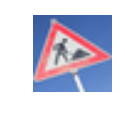

Wrong sign detection!
Sign detection result probabilites in percent:
Class 18 -                                    General caution: 30.05%
Class 11 -              Right-of-way at the next intersection: 22.43%
Class 24 -                          Road narrows on the right: 10.71%
Class 25 -                                          Road work: 7.59%
Class 19 -                        Dangerous curve to the left: 6.90%


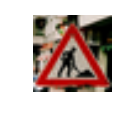

Correct sign detection!
Sign detection result probabilites in percent:
Class 25 -                                          Road work: 94.30%
Class 11 -              Right-of-way at the next intersection: 4.09%
Class 28 -                                  Children crossing: 0.52%
Class 27 -                                        Pedestrians: 0.29%
Class 18 -                                    General caution: 0.19%


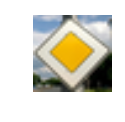

Correct sign detection!
Sign detection result probabilites in percent:
Class 12 -                                      Priority road: 99.91%
Class 41 -                                  End of no passing: 0.06%
Class 32 -                End of all speed and passing limits: 0.00%
Class 11 -              Right-of-way at the next intersection: 0.00%
Class 42 - End of no passing by vehicles over 3.5 metric tons: 0.00%


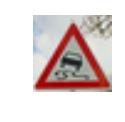

Wrong sign detection!
Sign detection result probabilites in percent:
Class 30 -                                 Beware of ice/snow: 60.31%
Class 11 -              Right-of-way at the next intersection: 28.83%
Class 28 -                                  Children crossing: 3.56%
Class 23 -                                      Slippery road: 3.55%
Class 21 -                                       Double curve: 0.89%


In [141]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
test = tf.nn.softmax(logits)
model = "LeNet2"
if model == "LeNet1":
    net = LeNet1(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet1"
else:
    net = LeNet2(x, keep_prob)
    logits = net["logits"]
    load_filename = "./lenet2"

load_filename += "-" + colorspace

test_detected_class = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, load_filename)
    for i, sign in enumerate(test_images_norm):
        fig, ax = plt.subplots(figsize=(1,1))
        ax.imshow(test_images[i].squeeze())
        ax.set_axis_off()
        plt.show(True)
        sign = np.reshape(sign, (1, sign.shape[0], sign.shape[1], sign.shape[2]))
        top = tf.nn.top_k(test, k=5)
        values, incicies = sess.run(top, feed_dict={x: sign, keep_prob: 1})
        print("%s sign detection!" % ("Correct" if incicies.flatten()[0] == test_labels[i] else "Wrong"))
        print("Sign detection result probabilites in percent:")
        for idx, val in zip(incicies.flatten(), values.flatten()):
            print("Class %2d - %50s: %.2f%%" % (idx, labels[idx], val*100))

### Analyze Performance

In [142]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    #saver.restore(sess, load_filename)
    test_accuracy = evaluate(test_images_norm, test_labels)
    print("Test image accuracy = %.3f" % test_accuracy)

INFO:tensorflow:Restoring parameters from ./lenet2-BW-12
Test image accuracy = 0.286


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# see above!

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from ./lenet2-BW-12


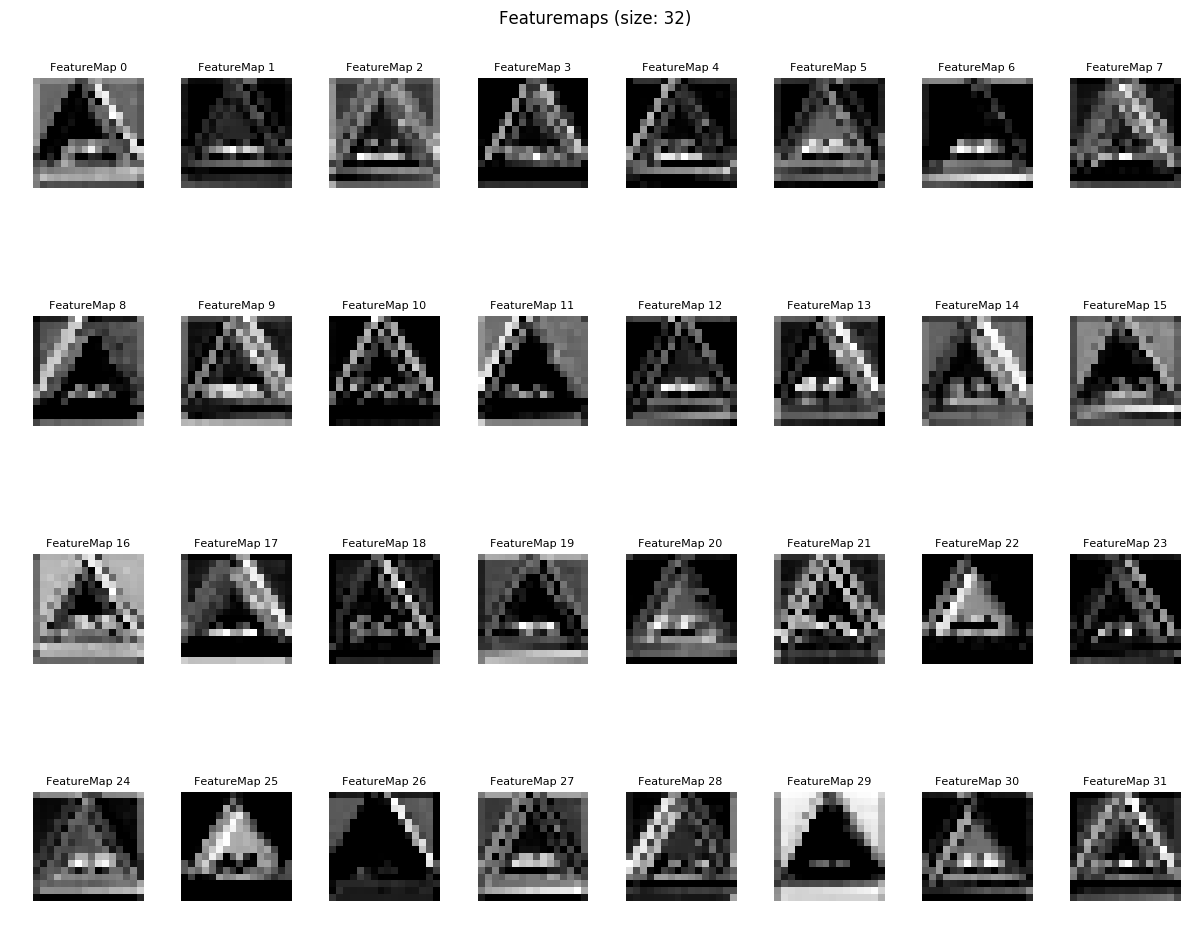

In [140]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # equalize and normalize data
    #image_input = equalize_dataset(image_input, colorspace)
    #image_input = center_normaize(image_input, X_mean, X_std)
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess, feed_dict={x: image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(12,10))
    plt.suptitle("Featuremaps (size: %d)" % featuremaps, fontsize=12)
    for featuremap in range(featuremaps):
        ax = plt.subplot(featuremaps//8, 8, featuremap+1) # sets the number of feature maps to show on each row and column
        #plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        ax.set_title('FeatureMap ' + str(featuremap), fontdict={'fontsize': 8})
        ax.set_axis_off()
        if activation_min != -1 and activation_max != -1:
            ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

    plt.tight_layout()


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    net = LeNet2(x, keep_prob)
    outputFeatureMap(test_images_norm, net["conv1"])